# Authorship Verification

## Loading in the needed libraries

In [1]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import scipy.spatial.distance as scidist

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import mpl_axes_aligner

## Loading in the data and metadata

In [2]:
def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text if l.text else "" for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text if p.text else "" for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            lemma = lemma or ""  # Ensure lemma is not None
            pos = pos or ""      # Ensure pos is not None
            
            for l, p in zip(lemma.split('+'), pos.split('+')):
                if p == 'NOU-P':
                    verse.append(('NOU-P', 'NOU-P'))
                else:
                    verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [3]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['genre'] == 'Epiek']
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

id  \
80   grimbergse_oorlog_cont                               
217  spiegel_der_sonden_fragm_ge1                         
11   bediedenisse_van_der_missen                          
104  roman_van_lancelot_fragm_br                          
126  madelgijs_fragm_d                                    
45   Der naturen bloeme, handschrift D                    
145  noch_van_salladine                                   
99   roman_van_jonathas_ende_rosafiere_fragm_a            
40   cyromanchie_van_den_pape_van_den_hamme_chiromantie   
154  ongeidentificeerd_4                                  

                                      title              author provenance  \
80   Grimbergse oorlog (cont)                NaN                 cdrom-mnl   
217  Spiegel der sonden                      NaN                 cdrom-mnl   
11   Bediedenisse van der missen             NaN                 cdrom-mnl   
104  Lancelot                                NaN                 cdrom-mnl   
126  Madelgijs                               NaN                 cdrom-mnl   
45   Der naturen bloeme                      Jacob van Maerlant  CG1         
145  Noch van Salladine                      NaN                 cdrom-mnl   
99   Jonathas ende Rosafiere                 NaN                 cdrom-mnl   
40   Cyromanchie van den pape van den Hamme  NaN                 cdrom-mnl   
154  Ongeïdentificeerd (4)                   NaN                 cdrom-mnl   

    date_range  genre        subgenre exclude  
80   1300-1350  Epiek  Historiografie  NaN     
217  1300-1400  Epiek  Didactiek       NaN     
11   1340-1360  Epiek  Religie         NaN     
104  1300-1350  Epiek  Arthur          NaN     
126  1340-1360  Epiek  Karel           NaN     
45   1287-1287  Epiek  Didactiek       NaN     
145  1390-1410  Epiek  Ridder          NaN     
99   1500-1520  Epiek  Ridder          NaN     
40   1440-1460  Epiek  Didactiek       NaN     
154  1300-1400  Epiek  Karel           NaN

In [4]:
works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml_galahad_BY-split/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'subgenre', 'text'])

Wrake van Ragisel                                 : 100%|█| 164/164 [00:09<00:00


In [5]:
work_df[work_df['title'] == 'Van den derden Eduwaert']

title            author  genre        subgenre  \
143  Van den derden Eduwaert  Jan van Boendale  Epiek  Historiografie   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

## Segmentation 

In [6]:
len(work_df[work_df['title'].str.contains('Eduwaert')]['text'].iloc[0])

1774

In [7]:
def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['subgenre']]
        
        if row['title'] == 'Van Saladijn':
            text = text[::2] + text[1::2]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=1773) # segment_length so that it includes at least 1 segment of Van den derden Eduwaert

100%|███████████████████████████████████████| 164/164 [00:00<00:00, 1422.15it/s]


In [8]:
len(segment_df[segment_df['title'].str.contains('duwaert')]['text'].iloc[0])

1773

In [9]:
segment_df

title              author  genre subgenre  segment-idx  \
0    Alexanders geesten   Jacob van Maerlant  Epiek  Ridder   1             
1    Alexanders geesten   Jacob van Maerlant  Epiek  Ridder   2             
2    Alexanders geesten   Jacob van Maerlant  Epiek  Ridder   3             
3    Alexanders geesten   Jacob van Maerlant  Epiek  Ridder   4             
4    Alexanders geesten   Jacob van Maerlant  Epiek  Ridder   5             
..                  ...                  ...    ...     ...  ..             
377  Walewein (Vostaert)  Pieter Vostaert     Epiek  Arthur   1             
378  Walewein ende Keye   NaN                 Epiek  Arthur   1             
379  Walewein ende Keye   NaN                 Epiek  Arthur   2             
380  Wrake van Ragisel    NaN                 Epiek  Arthur   1             
381  Wrake van Ragisel    NaN                 Epiek  Arthur   2             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  
0    [zede, stede, horen, verdoren, goed, doen, verstaan, waan, geraakt, maken, lof, af, verkeren, leren, goed, doen, deugd, mogen, leren, keren, verstaan, baraat, bestaan, vangen, geest, volleesten, verstaan, slaan, roek, boek, zagen, dag, beschrijven, leven, lijf, wijf, maken, raken, oorlog, togen, zijn, dwassen, hebben, leven, lieden, geschieden, wind, vinden, avontuur, artuur, NOU-P, klein, spel, gevallen, Hun, gestuinen, zijn, jaar, dwingen, lang, toe, hoe, bestaan, goed, voren, horen, zin, min, moeten, zoet, geslacht, macht, voren, geboren, geweld, behouden, onderdaan, ontvangen, NOU-P, prijs, aardrijk, rijk, NOU-P, vrij, doorvacht, kracht, held, weld, overslaan, gaan, land, hand, schip, NOU-P, jaar, waar, blijven, beschrijven, vrouwe, trouw, ...]  
1    [el, brengen, springen, ader, gader, beek, streek, gewaar, zijn, avontuur, keur, daar, vaar, toren, horen, jaar, are, wedemaand, wanen, middag, sage, stoven, kloof, verhit, wit, diep, lopen, zaan, dwaan, koud, menigvout, hand, vinden, tijd, lijden, kracht, onmacht, uiten, luid, dingen, jongeling, verdienen, vriend, naakt, staken, avontuur, sturen, vinden, wind, NOU-P, gewinnen, fel, wel, dan, man, moeder, stiefmoeder, deze, wezen, gader, vader, schaar, haar, land, brand, lijfneer, weer, bestaan, waan, aarde, weren, dat, zitten, wiel, vallen, heer, meer, katijf, lijf, zien, lachen, heer, immermeer, griek, zieke, mond, stonde, vervaard, waard, dol, vol, moeien, vernooien, natuur, avontuur, recht, knecht, lof, of, brengen, ...]                          
2    [toren, verliezen, heer, zeer, wonden, stond, been, klein, waan, bestaan, schaar, zijn, stede, lijden, man, winnen, daarin, zin, waart, vervaard, heer, weer, koninkrijk, kortelijk, algader, vader, uur, keur, beeld, held, vader, algader, zijn, das, mede, stede, welkom, vrome, stede, doen, heer, eer, doen, stede, gewezen, genezen, vaart, waart, zijn, gewis, natuur, geduren, affrik, aardrijk, land, sant, worm, storm, gebaar, zijn, reen, engeen, rivier, manier, waar, aldaar, na, NOU-P, kerk, gewerk, staan, raad, gebed, zeggen, zijn, openbaar, waan, vergaan, voren, verkiezen, zijn, varen, schaar, zijn, zand, eiland, hoog, droog, zee, wee, zand, land, land, sant, nacht, onzacht, vernemen, komen, drinken, lang, ...]                                          
3    [komen, wijn, fijn, geven

## Combinations

In [10]:
calib_df = segment_df[
    (segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem'})) | 
    (segment_df['title'].isin({'Jans teesteye'}))
]

trg_df = segment_df[segment_df['title'].isin({#'Brabantsche yeesten (B1-3)', 
                                              #'Brabantsche yeesten (B4-5)',
                                              'Brabantsche yeesten (B5)',
                                              'Korte kroniek van Brabant (korte versie 1)',
                                              'Korte kroniek van Brabant (lange versie)',
                                              'Der leken spieghel',
                                              'Jans teesteye',
                                              'Van den derden Eduwaert',
                                              'Melibeus',
                                              'Boec Exemplaer',
                                              'Dietsche doctrinale',
                                              'Boec vander wraken',
                                              #'Der ystorien bloeme'
                                             })]
                                              # 
                                              
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']

#calib_df = calib_df[calib_df['title'] != 'Heymelijchede der heymelijcheit']

### Interpolations

The following interpolations are removed from the works. Based on Vandyck, C., & Kestemont, M. (2024). Een auteur van formaat. Een attributie-onderzoek naar het oeuvre van de Limborch-dichter. Spiegel Der Letteren, 66(2), 111–167. https://doi.org/10.2143/SDL.66.2.3293546)

Historie van Troyen (De Pauw & Gailliard 1889-1892, vs. 14587, vs. 16492, vs. 28332)

* vanaf vs. 14591 (Dies is leden menghen dach) t.e.m. vs. 15858 (Sonder haere beider lachter), ed. De Pauw & Gailliard 1889-1892.
* vanaf vs. 16493 (Daer waster veel syt, seker des) t.e.m. vs. 17500 (Dat seit Dares diet ons bescreef.), ed. De Pauw & Gailliard 1889-1892.
* vanaf vs. 28336 (Die werlt is gedeilt in drien) t.e.m. vs. 29344 (Sy en doyet gheen tyt), ed. De Pauw & Gailliard 1889-1892.

Spiegel Historiael, Vijfde Partie (Besamusca 2009, 83)

* vanaf boek I, kap. 40-46, vs. 2818 (Die derde Heinric van Brabant) t.e.m. vs. 3543 (Mar hier gaen vore ander dinge), ed. Vander Linden e.a. 1906-1938
* vanaf boek II, kap. 44-55, vs. 3213 (Na dit doen, dit es waer) t.e.m. vs. 3976 (Ward met enen stride gehint), ed. Vander Linden e.a. 1906-1938. 
* vanaf boek III, kap. 2-21, vs. 71 (In desen tiden, alse nu, gelach) t.e.m. vs. 1403 (In andren landen ende andren lieden), ed. Vander Linden e.a. 1906-1938.
* vanaf boek IV, vs. 1 (Nu es die tijt so verre comen) t.e.m. vs. 5329 (Den viften boec ende, ende volmaken), ed. Vander Linden e.a. 1906-1938.

Boec vander Wrake (Van Anrooij 1995, 44)

* vanaf boek III, vs. 2273 (Die hem wel bepeynsen soude) t.e.m. vs. 2490 (Amen seghet allegader. Amen), ed. Snellaert 1869.

Der vrouwen heimelijcheit (Van Doorn & Kuiper 1976-1977, 539) 
* vanaf vs. 824 (Ic soude u leeren, sonder waen) t.e.m. vs. 925 (Maer van den magdekine niet so saen,), ed. Blommaert 1846.

Dietsche Lucidarius (Klunder 2005, 80-88)30
* vanaf vs. 357 (Clerc, die here, die niene verstarf ) t.e.m. vs. 436 (Om die genuechte van aertrike), ed. Blommaert 1851.
* vanaf vs. 889 (Lieve meester, maect mi wijs) t.e.m. vs. 1026 (Mit saligen sielen scone;), ed. Blommaert 1851.
* vanaf vs. 4680 (Of men den lichame in ’t kerchof ) t.e.m. vs. 4810 (Daer die engelen Gode loven), ed. Blommaert 1851.

In [11]:
calib_df[['author', 'title']].value_counts()

author                title                          
Jacob van Maerlant    Spiegel historiael (P1-P4)         50
                      Historie van Troyen                21
                      Rijmbijbel                         20
Lodewijk van Velthem  Merlijn-continuatie                14
                      Spiegel historiael (P5)            10
Jacob van Maerlant    Der naturen bloeme                 9 
                      Alexanders geesten                 8 
                      Sinte Franciscus leven             5 
Lodewijk van Velthem  Spiegel historiael (P4)            3 
Jan van Boendale      Jans teesteye                      2 
Jacob van Maerlant    Heymelijchede der heymelijcheit    1 
Name: count, dtype: int64

In [12]:
trg_df[['title']].value_counts()

title                                   
Der leken spieghel                          12
Boec vander wraken                          3 
Dietsche doctrinale                         3 
Brabantsche yeesten (B5)                    2 
Jans teesteye                               2 
Melibeus                                    2 
Korte kroniek van Brabant (lange versie)    1 
Van den derden Eduwaert                     1 
Name: count, dtype: int64

In [13]:
combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
print(combos['authorship'].value_counts())
combos.sample(5)

authorship
D    31
S    24
Name: count, dtype: int64


title1                   title2 authorship
3   Alexanders geesten       Rijmbijbel               S        
50  Jans teesteye            Spiegel historiael (P4)  D        
54  Spiegel historiael (P4)  Spiegel historiael (P5)  S        
31  Historie van Troyen      Merlijn-continuatie      D        
53  Merlijn-continuatie      Spiegel historiael (P5)  S

In [14]:
def identity(x):
    return x

def bigrams(text):
    for i in range(len(text)-1):
        if 'NOU-P' not in text[i:i+2]:
            yield '-'.join((sorted(text[i:i+2])))
            
def unigrams(text):
    for i in range(len(text)):
        if 'NOU-P' not in text[i]:
            yield text[i]
            
params = {'use_idf': True,
          'max_features': 500, # 10000 ook goed
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(list(calib_df['text']) + list(trg_df['text']))
X = vectorizer.transform(calib_df['text']).toarray()
X.shape

(143, 500)

In [15]:
# Sanity check to make sure all proper nouns are ignored and not present in the vector (important for Korte Kroniek)

# get the features from the vectorizer
feature_names = vectorizer.get_feature_names_out()
contains_nou_p = any("NOU-P" in feature for feature in feature_names)

# result
print("Does the feature list contain 'NOU-P'?", contains_nou_p)

Does the feature list contain 'NOU-P'? False


### Calibration

In [16]:
calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances = calib_distances[~calib_distances['distance'].isna()]
calib_distances

title1                   title2 authorship  distance
0     Alexanders geesten       Der naturen bloeme       S          0.777264
1     Alexanders geesten       Der naturen bloeme       S          0.766713
2     Alexanders geesten       Der naturen bloeme       S          0.807353
3     Alexanders geesten       Der naturen bloeme       S          0.813772
4     Alexanders geesten       Der naturen bloeme       S          0.788345
...                  ...                      ...      ..               ...
8309  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.473723
8310  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.436167
8311  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.362132
8312  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.436416
8313  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.464279

[8314 rows x 4 columns]

max(f1)=0.0 @ theta=0.2558


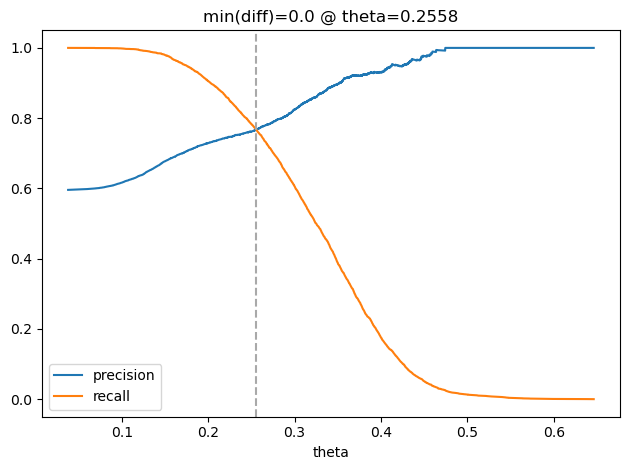

In [17]:
distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
diffs = np.abs(precisions - recalls)
max_diff_idx = np.array(diffs).argmin()
max_diff = diffs[max_diff_idx]
max_diff_th = thresholds[max_diff_idx]
print(f'max(f1)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.axvline(max_diff_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'min(diff)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')
plt.tight_layout()

In [18]:
calib_thresh = 1 - max_diff_th
calib_thresh

0.7442187558606124

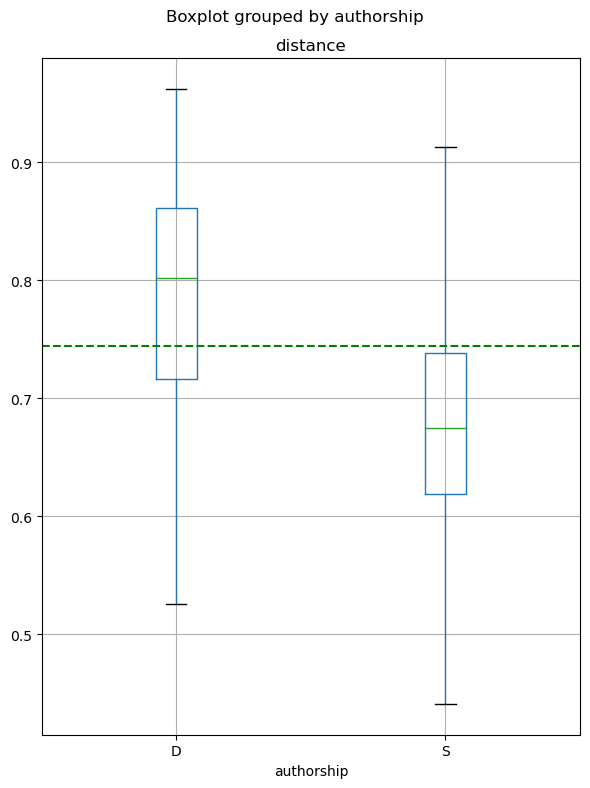

In [19]:
calib_distances.boxplot('distance', 'authorship', figsize=(6, 8), showfliers=False)
plt.axhline(calib_thresh, c='green', ls='--')
plt.tight_layout();

### Applied to Antwerp School

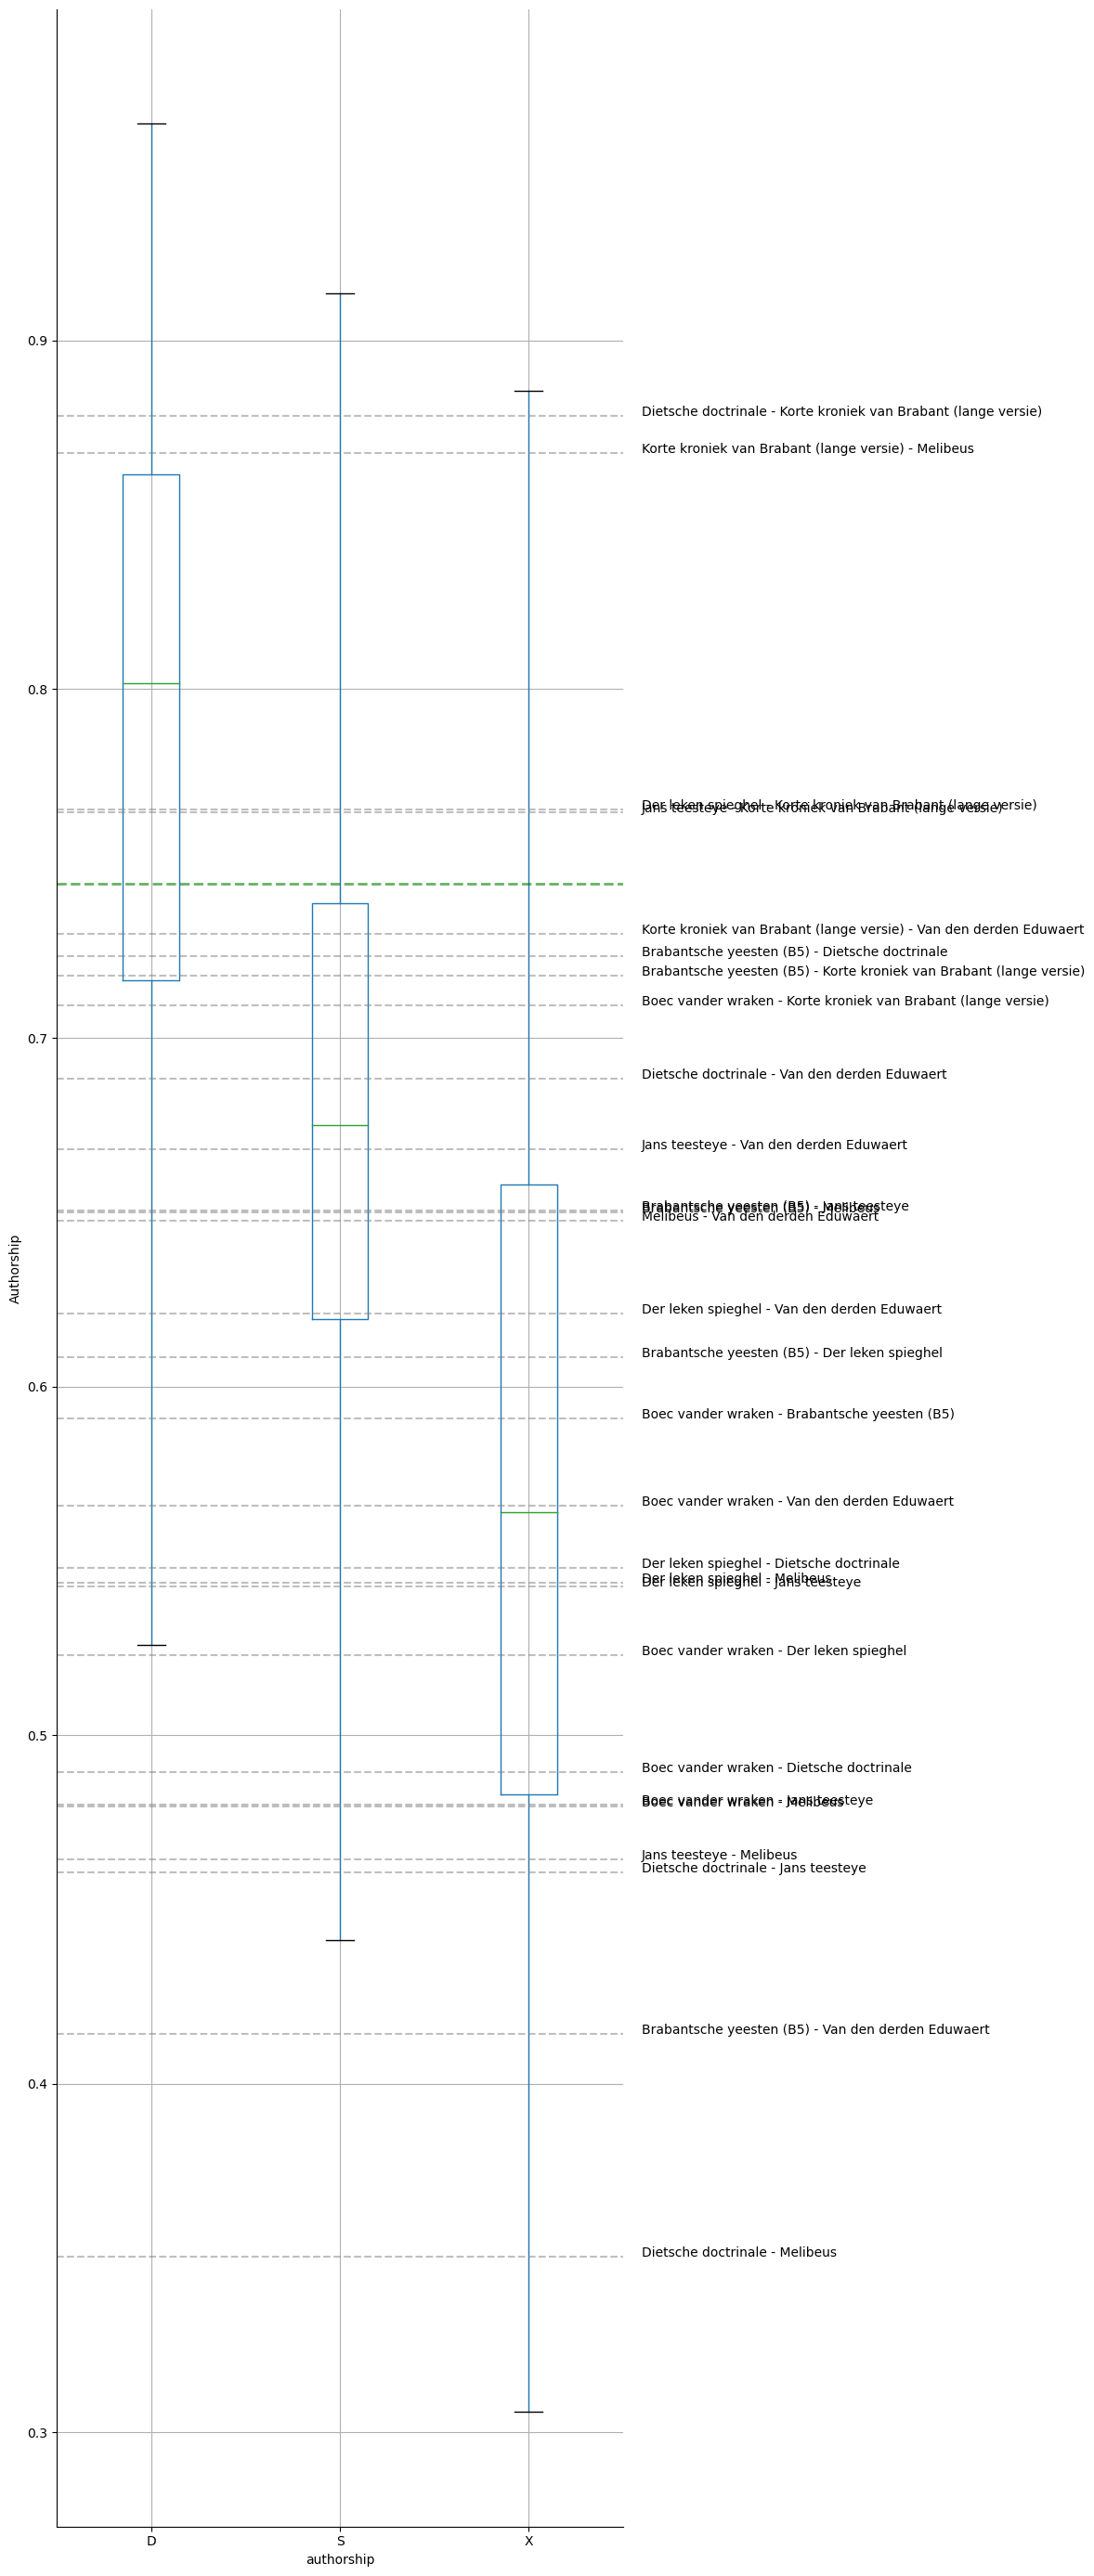

In [20]:
trg_X = vectorizer.transform(trg_df['text']).toarray()

combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'

trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
distances = pd.concat([calib_distances, trg_distances])

distances.boxplot('distance', 'authorship', figsize=(12, 28), showfliers=False)
sb.despine()
plt.axhline(calib_thresh, c='green', linewidth=2, ls='--', alpha=.6)

for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            plt.gca().axhline(d.mean(), c='grey', ls='--', alpha=.5)
            plt.annotate(' - '.join(m), xy=[plt.gca().get_xlim()[1]+0.1, d.mean()],
                         annotation_clip=False)
            
plt.title('')
plt.ylabel('Distance')
plt.ylabel('Authorship')
plt.suptitle('')

plt.tight_layout();

Observation:

1) It seems safe to conclude that all text below the lowest whisker of the DA boxplot are written by the same author:
* Dietsche doctrinale - Melibeus - Jans teesteye - Boec van der wraken
* Van den derden Eduwaert - Brabantsche yeesten (B5)
2) It also seems sure to conclude that Der leken spieghel may be added to the first list: 
* Dietsche doctrinale - Melibeus - Jans teesteye - Boec van der wraken - Der leken spieghel
3) Van den derden Eduwaert - Brabantsche yeesten (B5) are less sure to be added to aforementioned list, but probably belong in it.
4) It is hard to draw conclusions on the Korte Kroniek: the text was altered by the person who copied it (Heraut van Beyeren). I am researching to what extent.

For the poster:

## Networks

In [21]:
segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=1773)
segment_df.sample(5)

100%|███████████████████████████████████████| 164/164 [00:00<00:00, 1470.17it/s]


title            author  genre        subgenre  \
202  Reinaerts historie         NaN               Epiek  Dier             
193  Perchevael                 NaN               Epiek  Arthur           
237  Rijmkroniek van Woeringen  Jan van Heelu     Epiek  Historiografie   
61   Der leken spieghel         Jan van Boendale  Epiek  Didactiek        
65   Der minnen loep            Dirc Potter       Epiek  Didactiek        

     segment-idx  \
202  3             
193  3             
237  4             
61   12            
65   3             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  
202  [ontschieten, berijd, wijd, slaan, ongevoeg, geleide, heide, keren, regneren, scherpenibbe, hebben, vertijgen, vliegen, geding, brengen, ding, gaan, wijf, katijf, heide, beide, mond, hond, keel, veel, ik, rug, lijf, wijf, kin, en, mijsvel, fel, slag, zien, merken, sterken, hoofd, beroven, wij, ik, groot, dood, ontkomen, nemen, katijf, wijf, been, een, opsteken, krop, meer, zeer, jagen, mishagen, mijsbaar, zij, togen, dogen, merken, werk, nebbe, hebben, wraak, zaak, breken, versteken, kwaad, misdaad, wezen, deze, ontstellen, vertellen, konijn, taanschijn, vier, stier, verstoren, woord, trouw, vrouw, wreken, spreken, gebod, zot, geloven, verdoven, taal, maal, pelgrijm, zijn, meer, keer, mouw, vrouwe, geschieden, niet, raad, schade, toren, ...]                     
193  [klein, gemeen, kond, stond, stede, mede, komen, vernemen, haastelijk, vriendelijk, zaan, verstaan, vinden, hand, moeder, broeder, daar, naar, banderzijn, onblijden, vrouw, trouw, voorwaar, daar, onderling, ding, wel, spel, groot, doen, ding, koning, dat, zijn, scheiden, rijden, reden, godweet, zwaard, waren, dag, lachen, NOU-P, NOU-P, jonkvrouw, schouwen, verstaan, zaan, vaart, worden, verstaan, moeten, zien, dag, zeer, meer, verstaan, waan, zijn, bij, laten, zaat, al, zullen, NOU-P, sergeant, trouw, jonkvrouw, land, NOU-P, behaaglijk, gelijk, strijd, banderzijde, lieden, meisniede, dat, stad, NOU-P, hand, ros, wers, hij, vrij, speer, weer, komen, samen, pard, aarde, groot, doen, deert, zwaard, NOU-P, hand, ros, pers, stond, kond, ...]                          
237  [gelaat, stout, boud, beginnen, winnen, merken, sterken, laten, zaten, moet, goed, manier, banier, hand, sergeant, zijn, bewaren, onderkomen, naam, stade, daad, kond, bestaan, hoed, goede, lichaam, naam, geboren, kiezen, bastaard, bewaren, strijd, zijde, sergeant, hand, rijden, zijde, willen, houden, broek, hoek, liggen, wagen, rijden, lijden, niet, geschieden, warren, mirre, wijd, strijd, weder, neder, straat, laten, zijde, rijden, zeer, keer, worden, scharen, koeler, keren, naaste, haast, tehand, NOU-P, heer, zeer, koeler, heer, bij, zij, slaan, ondergaan, zijn, tijd, noot, bloot, strijd, zijde, dat, stad, rijden, lijden, gracht, kracht, schaar, overvaren, geheel, voordeel, eeuw, leeuw, graf, hoeven, ontweren, zwaard, verweren, ververen, geven, ...]           
61   [de, zijn, mikken, trekken, sprake, zaak, onderwinden, vinden, woord, oord, twint, bekennen, gembloes, altoos, kronist, wissen, jacobijn, NOU-P, hystoriaal, wel, wetten, met, klerk, werk, geschrift, gift, daartoe, toen, ondervinden, NOU-P, brengen, onderzoeken, eerzaam, betamen, zullen, al, gebuur, horen, geven, leven, wel, spel, zin,

In [22]:
import umap.umap_ as umap

def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               width=1000,
               height=800,
               outline_line_color="white")
    
    # Set background color
    p.background_fill_color = "#feecd1"  # Set the background colour for the poster
    p.background_fill_alpha = 1.0

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="5pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    
    show(p)
    
    return p

sub_df = segment_df[segment_df['subgenre'].isin({'Didactiek', 'Historiografie'})]
#sub_df = segment_df[segment_df['subgenre'].isin({'Historiografie'})]
#sub_df = segment_df[segment_df['subgenre'].isin({'Didactiek', 'Historiografie', 'Heiligenleven'})]
#sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]
#sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Brabantsche yeesten (B5)'})]

params = {'use_idf': True,
          'max_features': 500,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=20, random_state=42)
X = pca.fit_transform(BOW)

#tsne = TSNE(n_components=2)
#X = tsne.fit_transform(X)

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.20)

X = umap_model.fit_transform(X)

plot = scatterplot(X, sub_df, label_column='title', color_column='title')
plot

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


figure(id='p1004', ...)

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


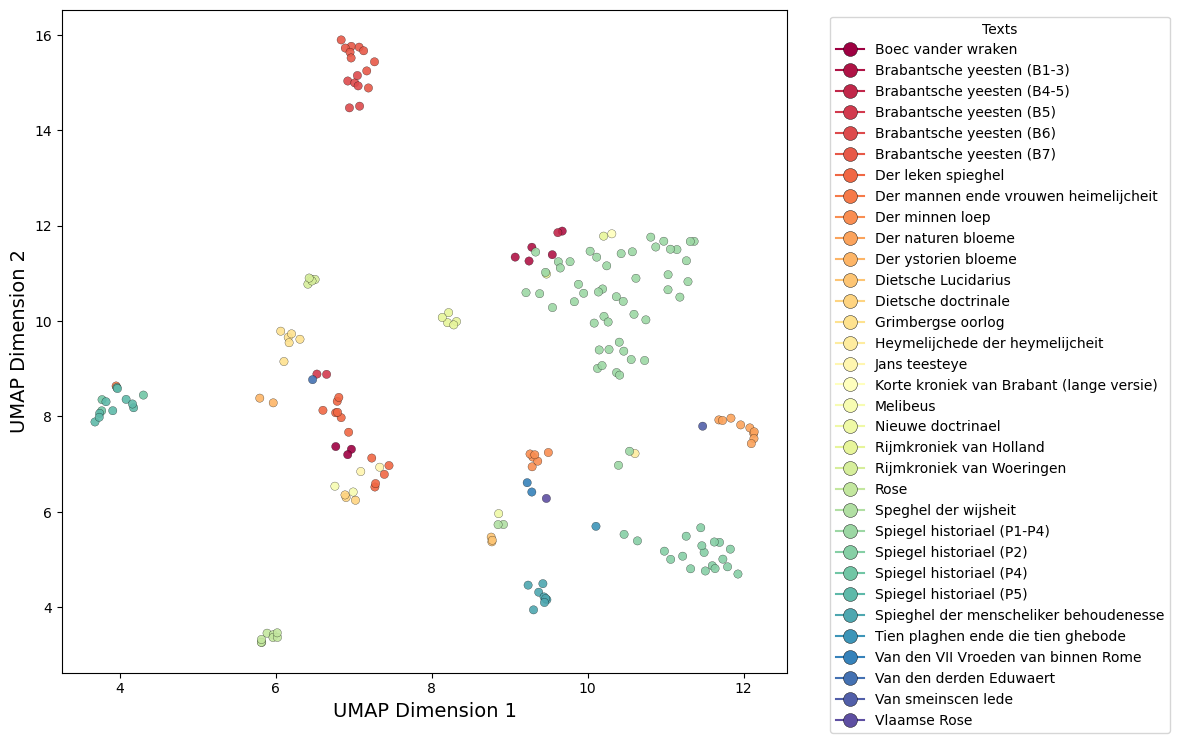

In [23]:
import umap.umap_ as umap

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=20, random_state=42)
X_pca = pca_model.fit_transform(BOW)

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.20, random_state=42)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(sub_df['title'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
text_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'{text}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, text in enumerate(text_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Texts", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
#plt.savefig('../figures/scatterplot_with_legend.svg', dpi=600, bbox_inches='tight')
plt.show()

In [24]:
import plotly.express as px
import pandas as pd

# Map categorical titles to a numeric scale for coloring
sub_df['title_numeric'] = pd.Categorical(sub_df['title']).codes

# Add UMAP coordinates back to the dataframe for ease of access
sub_df['UMAP Dimension 1'] = X_umap[:, 0]
sub_df['UMAP Dimension 2'] = X_umap[:, 1]

# Use a color scale based on the numeric mapping of titles
fig = px.scatter(sub_df, x='UMAP Dimension 1', y='UMAP Dimension 2', 
                 color='title_numeric', hover_data=['title'], 
                 labels={'title': 'title'}, 
                 color_continuous_scale='Spectral')  # You can change 'Viridis' to any other scale

# Add title and axis labels
fig.update_layout(title='UMAP Scatter Plot of Charter Texts by Scribes',
                  xaxis_title='UMAP Dimension 1',
                  yaxis_title='UMAP Dimension 2',
                  width=800,  # Adjust width
                  height=600,  # Adjust height to make it square
                  margin=dict(l=40, r=40, t=40, b=40)  # Adjust margins to avoid clipping
)

# Show interactive plot
fig.show()

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_71528/3830703244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['title_numeric'] = pd.Categorical(sub_df['title']).codes
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_71528/3830703244.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['UMAP Dimension 1'] = X_umap[:, 0]
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_71528/3830703244.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [25]:
# Want to include another text in sub_df? sub_df = segment_df[segment_df['title'].isin({''})]
sub_df = trg_df

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
BOW = StandardScaler().fit_transform(BOW)

## PCA

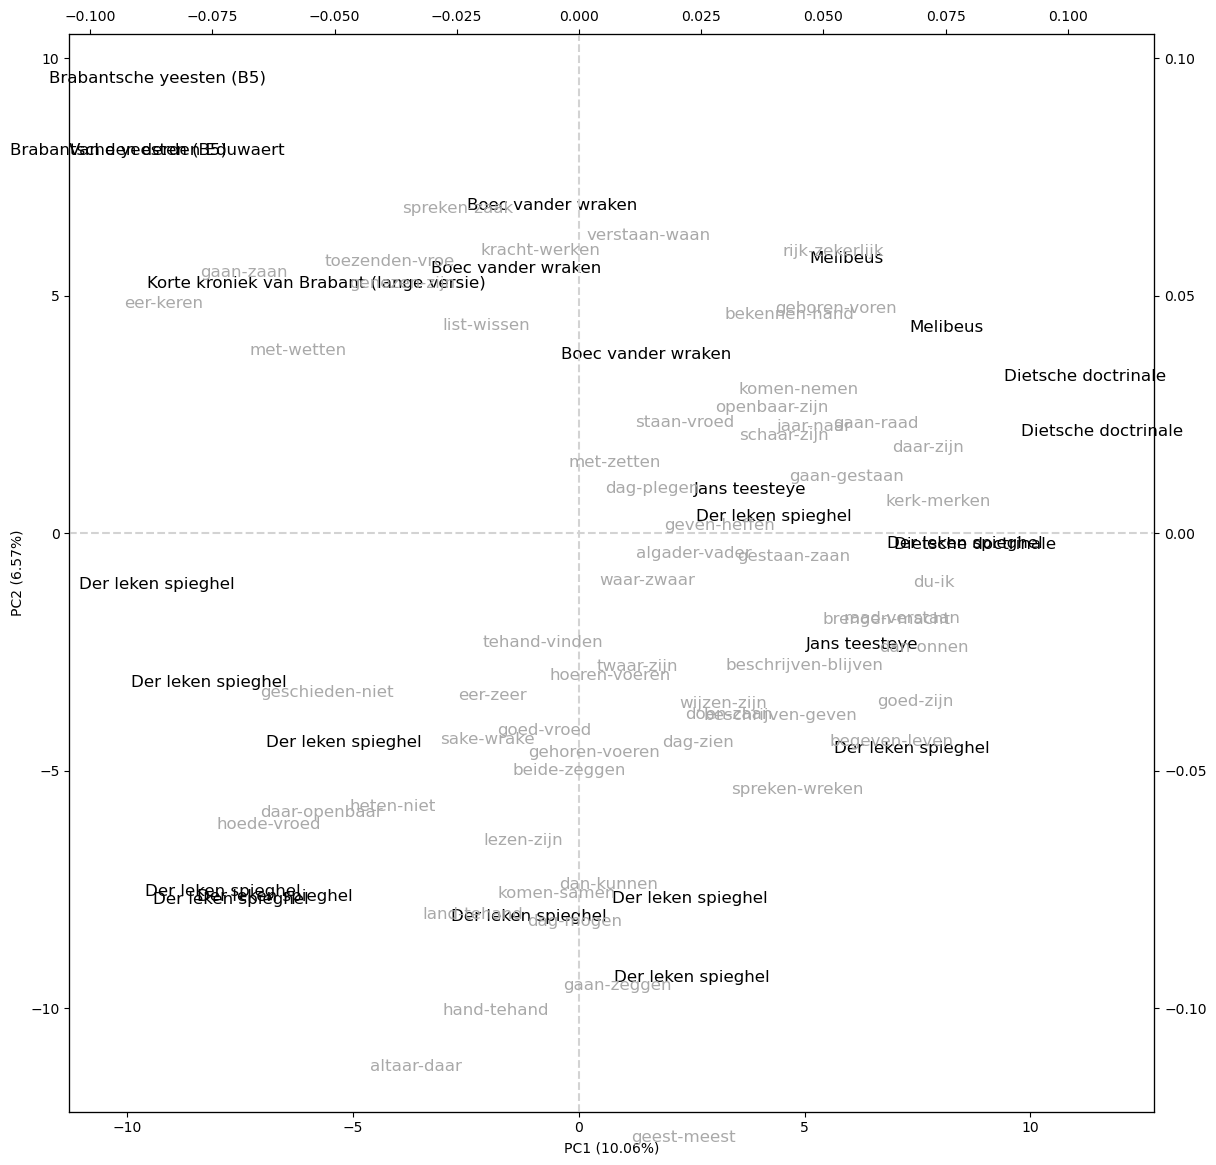

In [26]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

## Hierarchical clustering

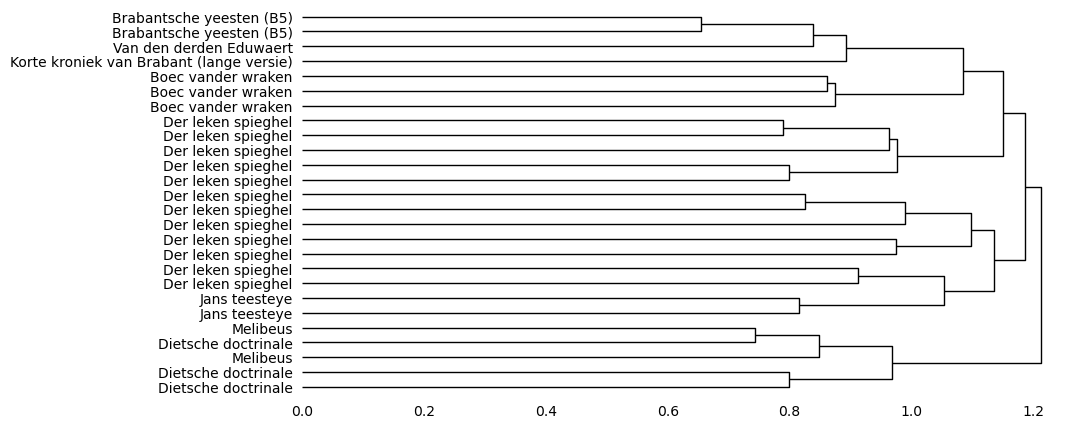

In [27]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy

# Reset index to ensure sequential indices for hierarchical clustering
trg_reset_df = trg_df.reset_index(drop=True)

# Generate labels from the reset DataFrame
labels = trg_reset_df['title'].tolist()

# Calculate pairwise distances
dm = scidist.pdist(BOW, 'cosine')

# Branch structure
linkage_object = hierarchy.linkage(dm, method='complete')

# Visualize
def plot_tree(linkage_object, labels, figsize=(10, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, 
            labels=labels, 
            ax=ax,
            link_color_func=lambda c: 'black',
            orientation='right',
            leaf_font_size=10)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

plot_tree(linkage_object, labels)

## Verification Ranking

In [28]:
params = {'use_idf': True,
          'max_features': 500,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
epics = segment_df[segment_df['genre'] == 'Epiek'].copy().reindex()
vectorizer.fit(epics['text'])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

(382, 500)

In [29]:
num_iter = 250
total_features = len(vectorizer.get_feature_names_out())
num_rnd_features = int(total_features * .5)
n_top_neighbors = 5

target_titles = [#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                 'Korte kroniek van Brabant (lange versie)',
                 'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken'
                ]

results = []

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    top_neighbors = neighbors.most_common(n_top_neighbors)
    summed = sum(neighbors.values())
    top_neighbors = [f'{k} ({(v / summed) * 100:.2f}%)' for k, v in top_neighbors]
    
    results.append([target_title] + top_neighbors)
    
results = pd.DataFrame(results, columns=['Target']+[f'Rank {i + 1}' for i in range(n_top_neighbors)])
results

Brabantsche yeesten (B5): 100%|███████████████████| 2/2 [00:00<00:00,  5.58it/s]
Korte kroniek van Brabant (korte versie 1): 0it [00:00, ?it/s]
Melibeus: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.47it/s]
Boec Exemplaer: 0it [00:00, ?it/s]
Boec vander wraken: 100%|█████████████████████████| 3/3 [00:00<00:00,  5.51it/s]


Target  \
0  Korte kroniek van Brabant (lange versie)     
1  Brabantsche yeesten (B5)                     
2  Korte kroniek van Brabant (korte versie 1)   
3  Der leken spieghel                           
4  Jans teesteye                                
5  Van den derden Eduwaert                      
6  Melibeus                                     
7  Boec Exemplaer                               
8  Dietsche doctrinale                          
9  Boec vander wraken                           

                                Rank 1                               Rank 2  \
0  Brabantsche yeesten (B1-3) (46.80%)  Spiegel historiael (P1-P4) (21.20%)   
1  Van den derden Eduwaert (74.80%)     Brabantsche yeesten (B1-3) (8.00%)    
2  None                                 None                                  
3  Boec vander wraken (22.00%)          Dietsche doctrinale (21.33%)          
4  Dietsche doctrinale (44.00%)         Boec vander wraken (22.00%)           
5  Brabantsche yeesten (B5) (80.40%)    Brabantsche yeesten (B1-3) (7.60%)    
6  Dietsche doctrinale (90.40%)         Boec vander wraken (6.40%)            
7  None                                 None                                  
8  Melibeus (79.07%)                    Jans teesteye (11.73%)                
9  Jans teesteye (32.93%)               Dietsche doctrinale (22.93%)          

                                Rank 3                              Rank 4  \
0  Brabantsche yeesten (B4-5) (14.00%)  Rijmkroniek van Holland (8.00%)      
1  Roman der Lorreinen II (3.60%)       Der leken spieghel (2.80%)           
2  None                                 None                                 
3  Jans teesteye (16.00%)               Brabantsche yeesten (B4-5) (7.43%)   
4  Melibeus (21.00%)                    Der leken spieghel (12.00%)          
5  Boec vander wraken (6.00%)           Spiegel historiael (P5) (1.60%)      
6  Jans teesteye (1.60%)                Der leken spieghel (1.40%)           
7  None                                 None                                 
8  Der leken spieghel (5.73%)           Boec vander wraken (2.40%)           
9  Melibeus (20.53%)                    Der leken spieghel (8.00%)           

                             Rank 5  
0  Rijmbijbel (5.60%)                
1  Rijmkroniek van Holland (2.20%)   
2  None                              
3  Melibeus (7.07%)                  
4  Brabantsche yeesten (B5) (0.40%)  
5  Der leken spieghel (1.20%)        
6  Grimbergse oorlog (0.20%)         
7  None                              
8  Enaamse Codex (0.53%)             
9  Van den derden Eduwaert (7.47%)

## Feature analysis

On the Antwerp School

In [30]:
BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                 'Brabantsche yeesten (B5)',
                                 'Korte kroniek van Brabant (korte versie 1)',
                                 'Korte kroniek van Brabant (lange versie)',
                                 'Der leken spieghel', 'Jans teesteye', 
                                 'Van den derden Eduwaert', 'Melibeus', 'Boec Exemplaer', 
                                 'Dietsche doctrinale', 'Boec vander wraken'])

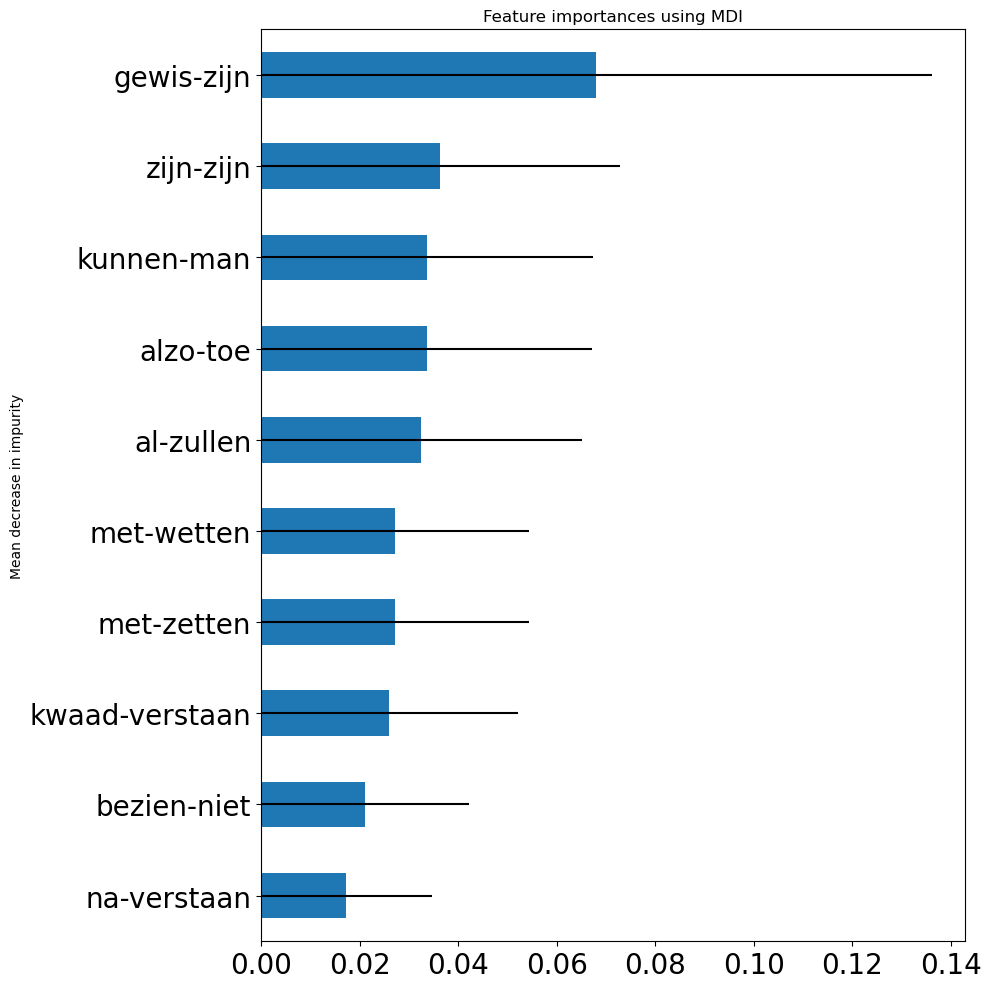

In [31]:
classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



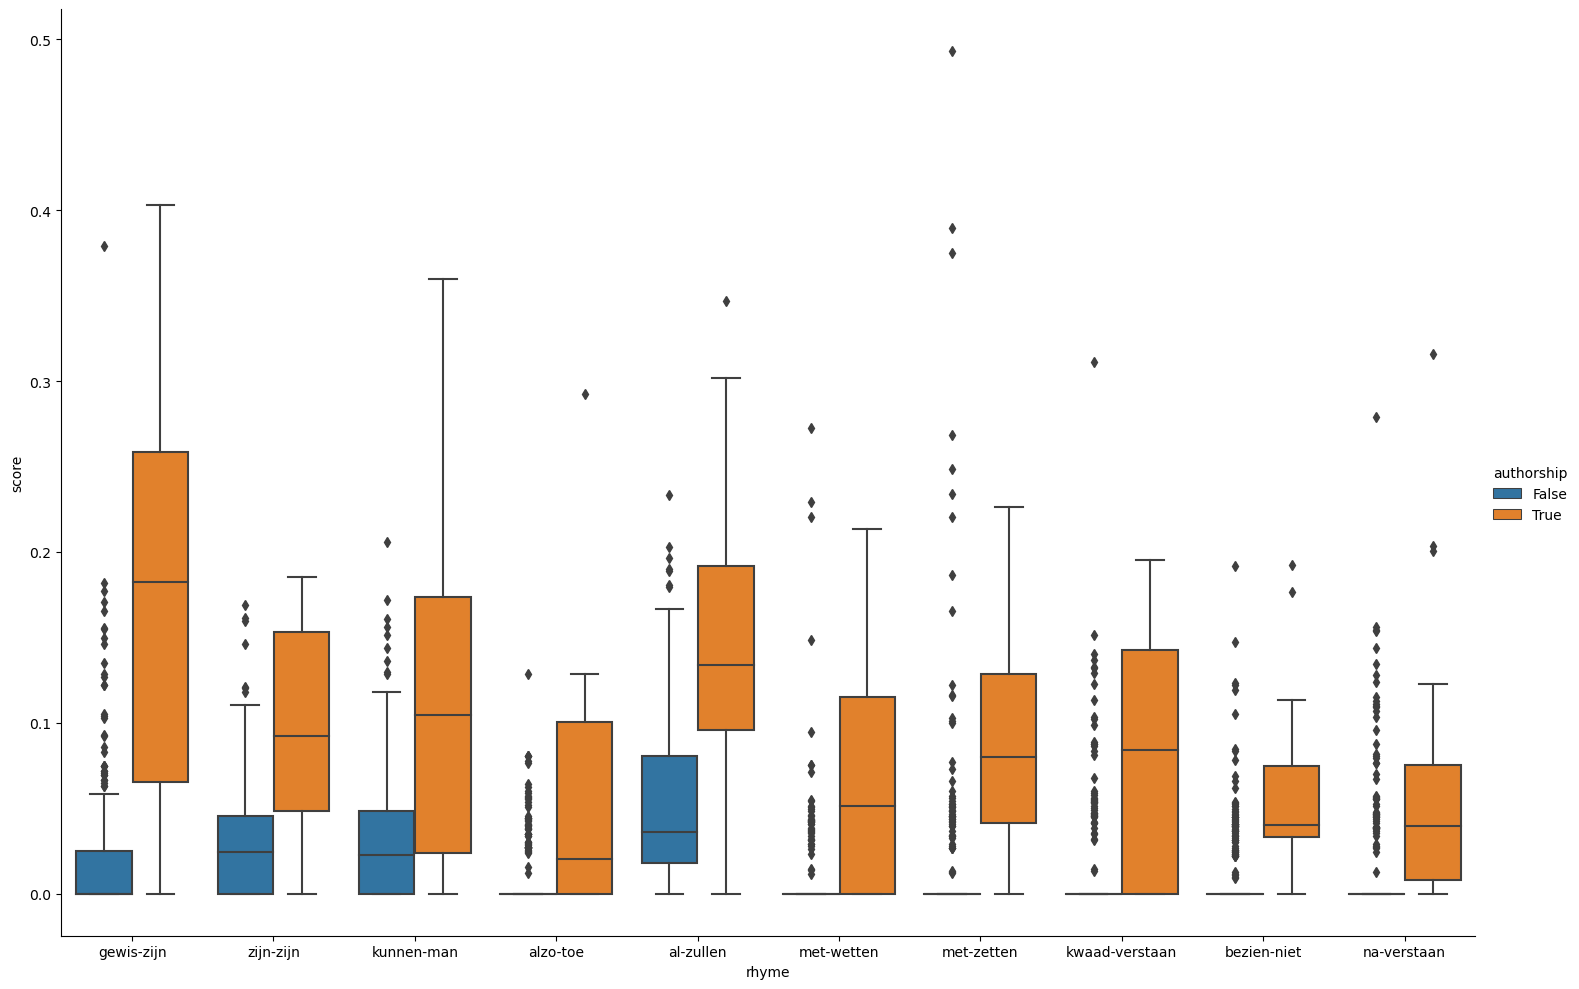

In [32]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);

On a particular work: Jans teesteye

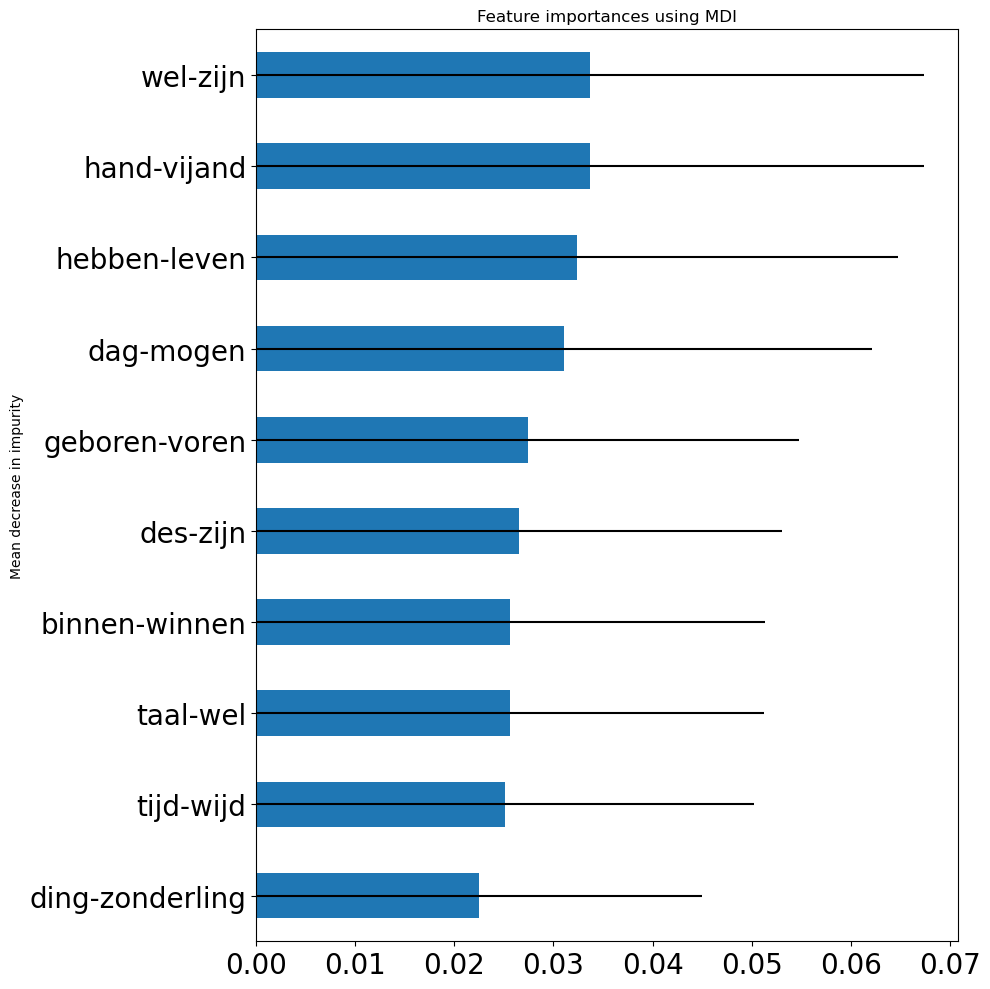

In [33]:
epics = epics[epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                   'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                                    'Korte kroniek van Brabant (lange versie)',
                                     'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                                     'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken'])]
segment_X = vectorizer.transform(epics['text']).toarray()

BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'] == 'Jans teesteye'

classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



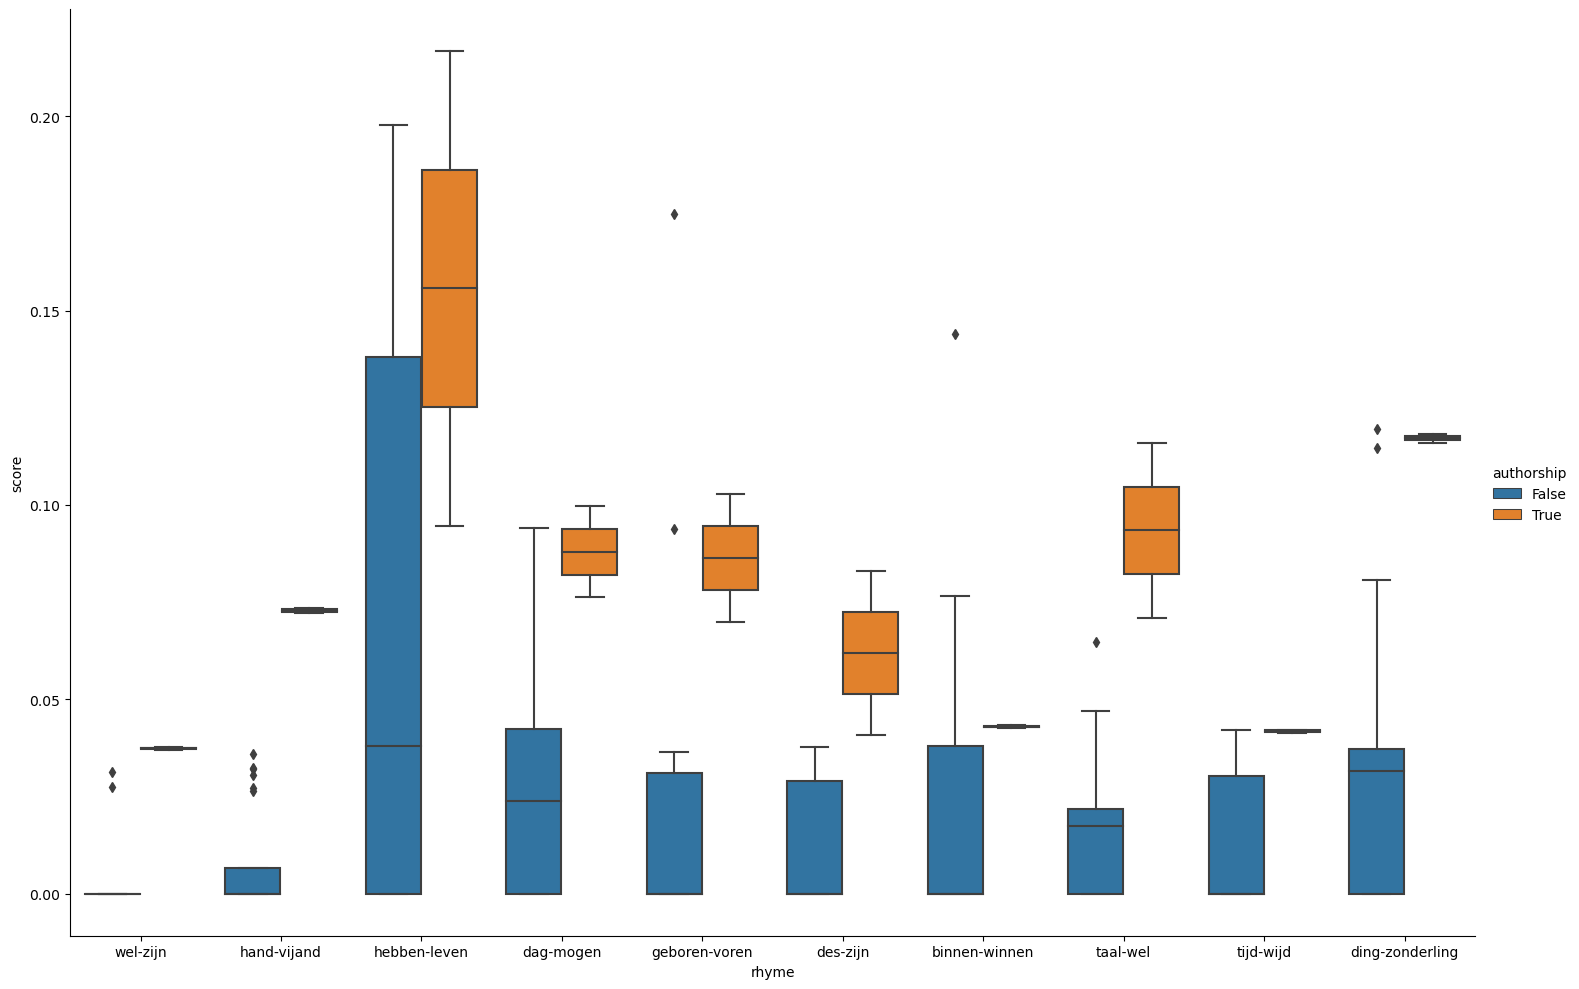

In [34]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);